# Project: Retinal vessel segmentation

The segmentation of retinal blood vessels from eye fundus images is of great significance for early diagnosis of eye-related diseases such as diabetes and hypertension.

The goal of this project is to read an eye fundus image like the following:
![](https://dlsi.ua.es/~pertusa/tvainput21.png)

And extract the blood vessels as can be seen in the corresponding ground-truth sample:

![](https://dlsi.ua.es/~pertusa/tvagt21.png)

All the images for this project are extracted from the [Drive](https://drive.grand-challenge.org) dataset.

For this task you can use any computer vision technique **except by deep neural networks, that are not allowed in this project**.

## Implementation

To begin with the project, first download from moodle the folder with all the images and upload it to google drive.

Then, import the following libraries (you can add more):

In [ ]:
import os
from google.colab import drive
import cv2 as cv

drive.mount('/content/drive')

%matplotlib inline
from matplotlib import pyplot as plt

db_path =  "/content/drive/MyDrive/TVAProject"

Mounted at /content/drive


In [ ]:
def single_IoU(img_name, plot_images=False, plot_step_iamges=False):

    # Apply segmentation
    input_img = os.path.join(db_path, 'input', img_name)
    obtained = vessel_segmentation(input_img, plot_step_iamges)

    # Path of the target (ground truth) image
    path_target = os.path.join(db_path, 'gt', img_name)
    solution = cv.imread(path_target, cv.IMREAD_GRAYSCALE)

    if plot_images:
      # Show obtained results
      plt.imshow(obtained, cmap=plt.get_cmap('gray'))
      plt.show()

    # IoU calculation
    intersectionAB = cv.countNonZero(obtained & solution)
    unionAB = cv.countNonZero(obtained | solution)
    score = intersectionAB / unionAB
    print("Image {} - IoU={}".format(path_input, score))

    return score

Now you should edit the following function to segment the image and return the obtained segmentation. This is only a simple (basic) skeleton that obviously is not performing well. Your project's goal is basically to complete this function. You can read the attached papers in Moodle to get ideas for the segmentation.

In [ ]:
def remove_circular_objects(segmented_image, min_area=50, circularity_threshold=0.7):
    # Detect connected components
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(segmented_image, connectivity=8)

    # Create a mask for non-round objects
    non_circular_mask = np.zeros(segmented_image.shape, dtype=np.uint8)

    for i in range(1, num_labels):  # Start at 1 to ignore background
        area = stats[i, cv.CC_STAT_AREA]
        if area < min_area:  # Filter out objects that are too small
            continue

        # Get the outline of the object
        obj_mask = (labels == i).astype(np.uint8)
        contours, _ = cv.findContours(obj_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if contours:
            perimeter = cv.arcLength(contours[0], True)
            if perimeter > 0:  # Avoid division by zero
                circularity = 4 * np.pi * (area / (perimeter ** 2))
                # If the object is not circular, add it to the mask
                if circularity < circularity_threshold:
                    non_circular_mask = cv.bitwise_or(non_circular_mask, obj_mask)

    return non_circular_mask

In [290]:
def self_plot(*imgs):
  """
  Draws all the images it receives as an argument.

  Args:
    *imgs: A variable number of images.
  """
  for img in imgs:
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [280]:
def apply_circular_mask(img):
    mask_circular = np.zeros_like(img, dtype=np.uint8)
    height, width = img.shape
    center = (width // 2, (height+15) // 2)
    radius = min(center[0], center[1]) - 20  # Edge adjustment
    cv.circle(mask_circular, center, radius, 255, -1)
    return cv.bitwise_and(img, mask_circular)

In [275]:
def get_green_chanel(color_image):
  green_channel = color_image[:,:,1]
  return green_channel

In [293]:
import cv2 as cv
import numpy as np

def vessel_segmentation(input_image, plot_step_iamges=False):
    # 1. Load the image
    color_image = cv.imread(input_image, cv.IMREAD_COLOR)

    # 2. Use green channel as grayscale image
    gray_image = get_green_chanel(color_image)

    # 3. Apply CLAHE to improve contrast
    grid_size = 4
    clahe = cv.createCLAHE(clipLimit=2.2, tileGridSize=(grid_size, grid_size))
    contrast_enhanced = clahe.apply(gray_image)

    # 4. Median filter to reduce noise
    median_mask_size = 3
    denoised = cv.medianBlur(contrast_enhanced, median_mask_size)

    # 5. Apply a Gaussian filter to reduce noise
    gaussian_mask_size = 7
    blurred = cv.GaussianBlur(denoised, (gaussian_mask_size, gaussian_mask_size), 0)

    # 6. Adaptive thresholding for segmenting veins
    blockSize = 15
    C = 2
    segmented_image = cv.adaptiveThreshold(
        blurred,
        255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV,
        blockSize,
        C
    )

    # 7. Refine the result with morphological operations
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened = cv.morphologyEx(segmented_image, cv.MORPH_OPEN, kernel, iterations=1)

    # 8. Remove small circular objects
    cleaned_whitout_circles = remove_circular_objects(opened)

    # 9. Remove circle from eyeball
    cleaned_without_big_circles = apply_circular_mask(cleaned_whitout_circles)

    if plot_step_iamges:
      # Show obtained results
      print("------------------------------------")
      self_plot(
        color_image,
        gray_image,
        contrast_enhanced,
        denoised,
        blurred,
        segmented_image,
        opened,
        cleaned_whitout_circles,
        cleaned_without_big_circles)

    return cleaned_without_big_circles


Your project will be evaluated with the Intersection over Union (IoU) metric, commonly used in segmentation tasks. This is the function to read a ground truth image and return the IoU considering your segmented image.

This is the evaluation method that reads all the images from the input folder and gets the mean IoU for all of them. This is the score of your project, the higher the better.

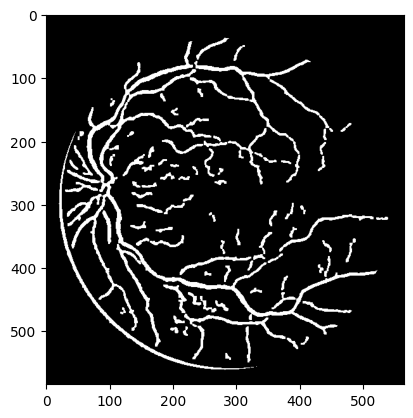

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5168515205724508


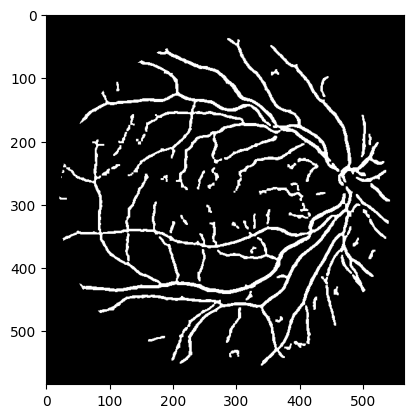

Image /content/drive/MyDrive/TVAProject/input - IoU=0.6184834705665478


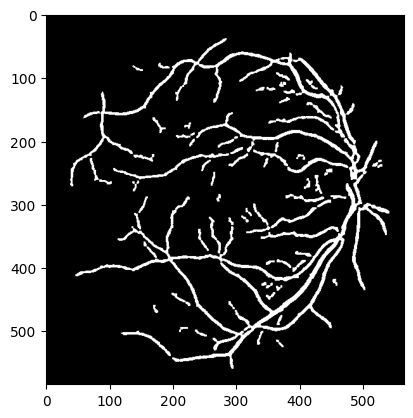

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5854982777745344


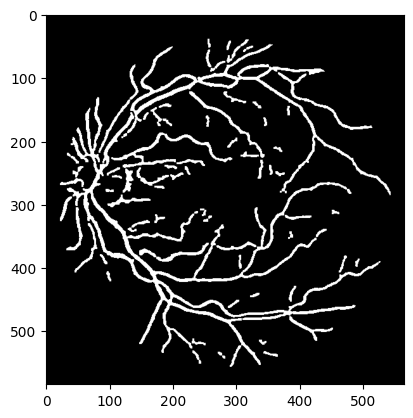

Image /content/drive/MyDrive/TVAProject/input - IoU=0.6014729950900164


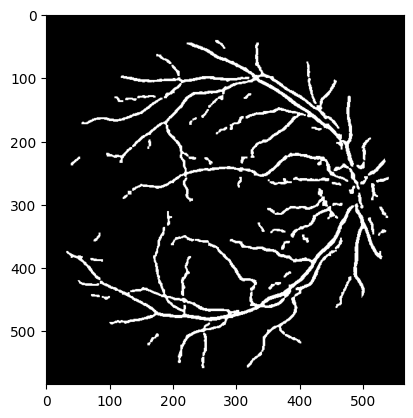

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5785820682660919


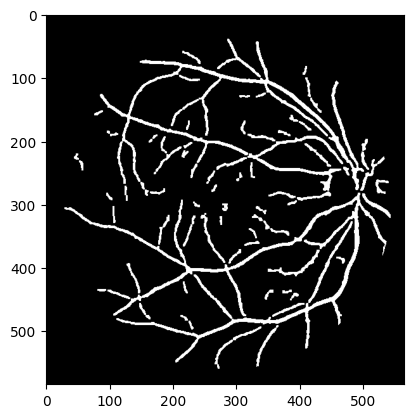

Image /content/drive/MyDrive/TVAProject/input - IoU=0.6274211925560198


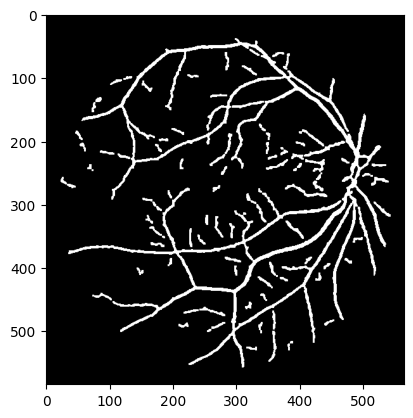

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5745922327462208


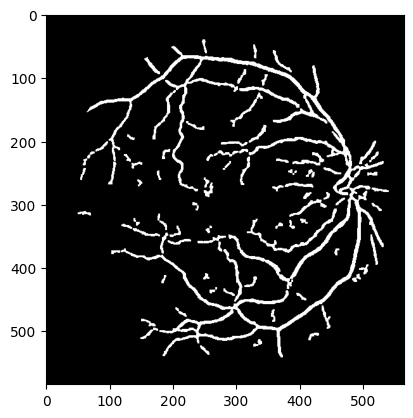

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5557383673940653


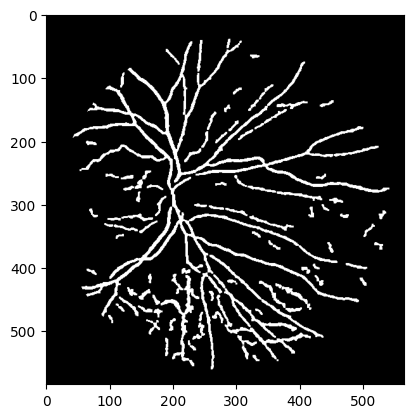

Image /content/drive/MyDrive/TVAProject/input - IoU=0.4863438520130577


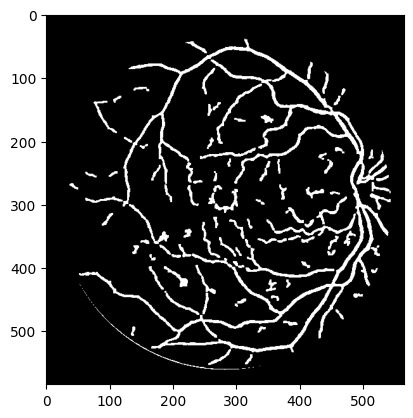

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5311197705255182


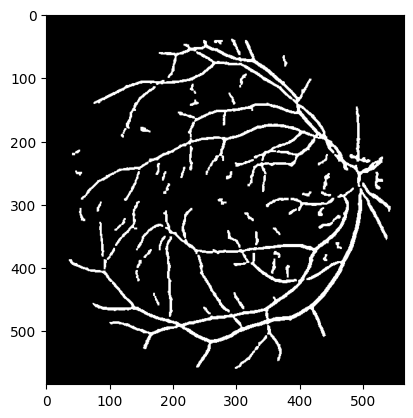

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5569936067363168


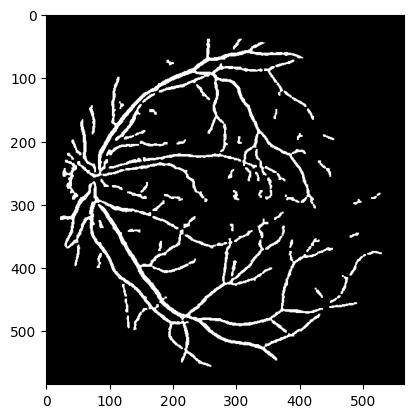

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5682030652426414


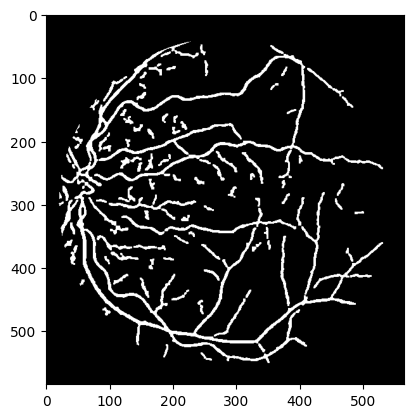

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5062586926286509


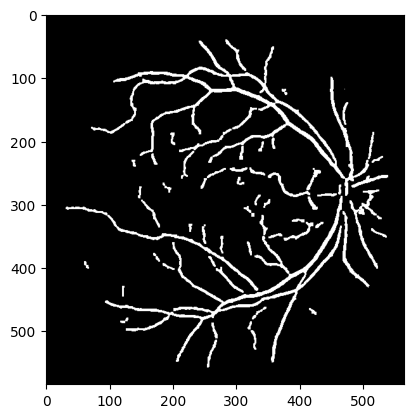

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5703003506632108


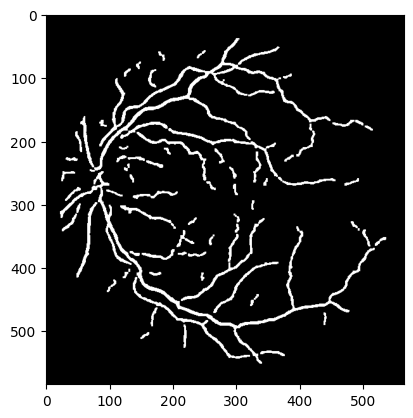

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5596074707185819


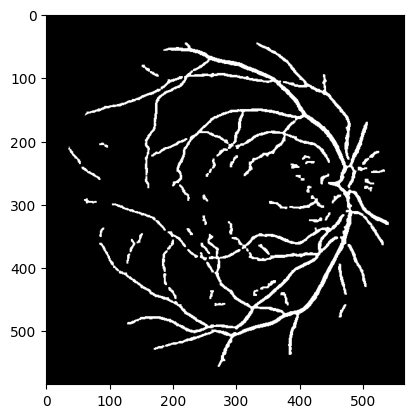

Image /content/drive/MyDrive/TVAProject/input - IoU=0.569454405031169


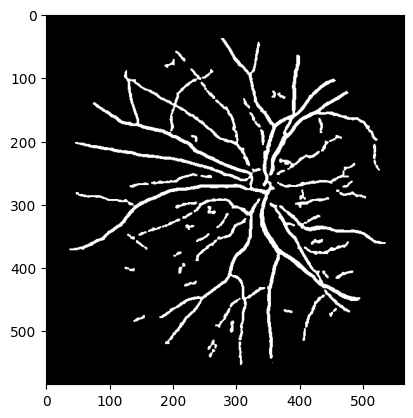

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5758879915043457


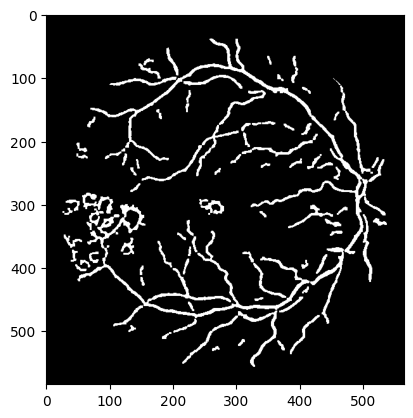

Image /content/drive/MyDrive/TVAProject/input - IoU=0.49561521493516975


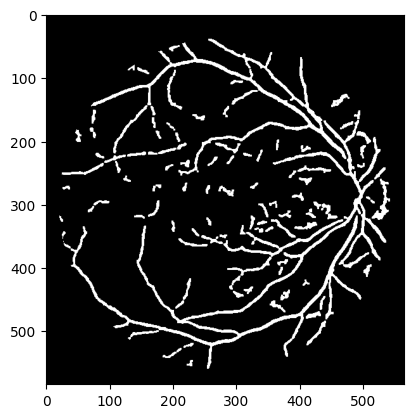

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5243109958133203


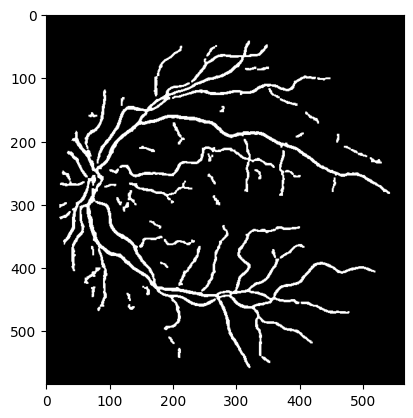

Image /content/drive/MyDrive/TVAProject/input - IoU=0.5815138489567024
------------------------------------
Mean IoU=0.5592124694867314


In [295]:

meanIoU=0

path_input = os.path.join(db_path, 'input')

# List images in input folder
imgs = [f for f in os.listdir(path_input) if f.endswith('.png')]
#print(imgs)

# For each image
for img in imgs:
    meanIoU += single_IoU(img_name=img, plot_images=True, plot_step_iamges=False)

# Average
meanIoU /= len(imgs)
print("------------------------------------")
print("Mean IoU={}".format(meanIoU))
